# At the end of  Part 1

Problem Statement : 

        1. Predict future storage of the reservoir 
        2. Why inflow in July,2022 is negative ?

The construction of Glen Canyon Dam in 1964 created Lake Powell. (an artificial reservoir) Both are located in north-central Arizona near the Utah border. Lake Powell acts as a holding tank for outflow from the Colorado River Upper Basin States: Colorado, New Mexico, Utah and Wyoming.

Water source of Colorado River -> La Poudre Pass Lake located in the Rocky Mountains of northern Colorado in the United States


Data source : https://www.kaggle.com/datasets/johnyoungsorensen/lake-powell-water-level

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download johnyoungsorensen/lake-powell-water-level
! unzip /content/lake-powell-water-level.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/2.07M [00:00<?, ?B/s]
100% 2.07M/2.07M [00:00<00:00, 146MB/s]
Archive:  /content/lake-powell-water-level.zip
  inflating: Lake Powell Updated.csv  
  inflating: Lake Powell.csv         


In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

plt.rcParams["figure.figsize"] = (12,10)

In [6]:
df = pd.read_csv('/content/Lake Powell.csv')
print(df.shape)
df.rename(columns={'datetime':'Date'},inplace=True)
df.index = pd.to_datetime(df['Date'])
df.head(5)

(21665, 11)


Date    inflow  total release  evaporation  bank storage  \
Date                                                                         
1963-03-11  1963-03-11  4751.424            NaN          NaN           NaN   
1963-03-12  1963-03-12  4680.234            NaN          NaN           NaN   
1963-03-13  1963-03-13  4645.656            NaN          NaN           NaN   
1963-03-14  1963-03-14  4748.373         1300.0          0.0           NaN   
1963-03-15  1963-03-15  4730.067         1260.0          0.0           NaN   

            storage  unregulated inflow  pool elevation  power release  area  \
Date                                                                           
1963-03-11      NaN                 NaN             NaN            NaN   NaN   
1963-03-12      NaN                 NaN             NaN            NaN   NaN   
1963-03-13      NaN                 NaN             NaN            NaN   NaN   
1963-03-14      NaN                 NaN             NaN            NaN   NaN   
1963-03-15      NaN                 NaN             NaN            NaN   NaN   

            bypass release  
Date                        
1963-03-11             NaN  
1963-03-12             NaN  
1963-03-13             NaN  
1963-03-14             NaN  
1963-03-15             NaN

In [7]:
df.fillna(method='bfill',inplace=True)
df.isnull().sum()

cols = ['inflow', 'total release', 'evaporation', 'bank storage',
       'storage', 'unregulated inflow', 'pool elevation', 'power release',
       'area', 'bypass release']
for x in cols:
    df[x]=df[x].diff(7)
df=df[7:]

df['final_inflow']=df['inflow']+df['unregulated inflow']
df['final_outfow'] = df['total release']+df['evaporation']+df['bypass release']
df['final_storage'] = df['storage'] - df['bank storage'] -  df['final_inflow'] - df['final_outfow']

train = df[:'2022-04-30']
test = df['2022-05-01':]

<ipython-input-7-1c4ae598e3ed>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_inflow']=df['inflow']+df['unregulated inflow']
<ipython-input-7-1c4ae598e3ed>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_outfow'] = df['total release']+df['evaporation']+df['bypass release']
<ipython-input-7-1c4ae598e3ed>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

# Part 2 starts here

In [8]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

In [10]:
def interactive_plot(df,forcast,x):
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(name = 'actual value', mode = 'markers',x = list(df['Date']),y = list(df[x]),
                       marker=dict(color='#f6d100',line=dict(width=1))))
    fig.add_trace(go.Scatter(name = 'trend',mode = 'lines',x = list(forecast['ds']),y = list(forecast['yhat']),
                        marker=dict(color='#250000',line=dict(width=1)))) 

    fig.add_trace(go.Scatter(name = 'upper band',x = list(forecast['ds']),y = list(forecast['yhat_upper']),fill=None,
                             mode='lines',line_color= '#ff80ad'))
    fig.add_trace(go.Scatter(name= 'lower band',x = list(forecast['ds']),y = list(forecast['yhat_lower']),fill='tonexty',
                             mode='lines',line_color= '#ff80ad'))

    fig.show()

## Using Prophet for prediction (on daily scale) 
    1. future storage for next 3 months
    2. future inflow for next 3 months
    3. check anomaly in prediction

**Prophet with additional parameters (on daily dataframe)**

In [11]:
xdat = train[['Date', 'final_storage']].rename(columns={'Date': 'ds', 'final_storage': 'y'})

DEBUG:cmdstanpy:input tempfile: /tmp/tmpacdc5kae/n3e4k8tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpacdc5kae/8whiwkun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63572', 'data', 'file=/tmp/tmpacdc5kae/n3e4k8tt.json', 'init=/tmp/tmpacdc5kae/8whiwkun.json', 'output', 'file=/tmp/tmpacdc5kae/prophet_modelsb4k8ihs/prophet_model-20221214023040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:30:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:30:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.8/dist-packages/prophet/forecaster.py:1288: RuntimeWarning: overflow encountered in exp
  return cap / (1 + np.exp(-k_t * (t - m_t)))
/usr/local/lib/python3.8/dist-packages/prophet/forecaster.py:1731: RuntimeWarning: ove

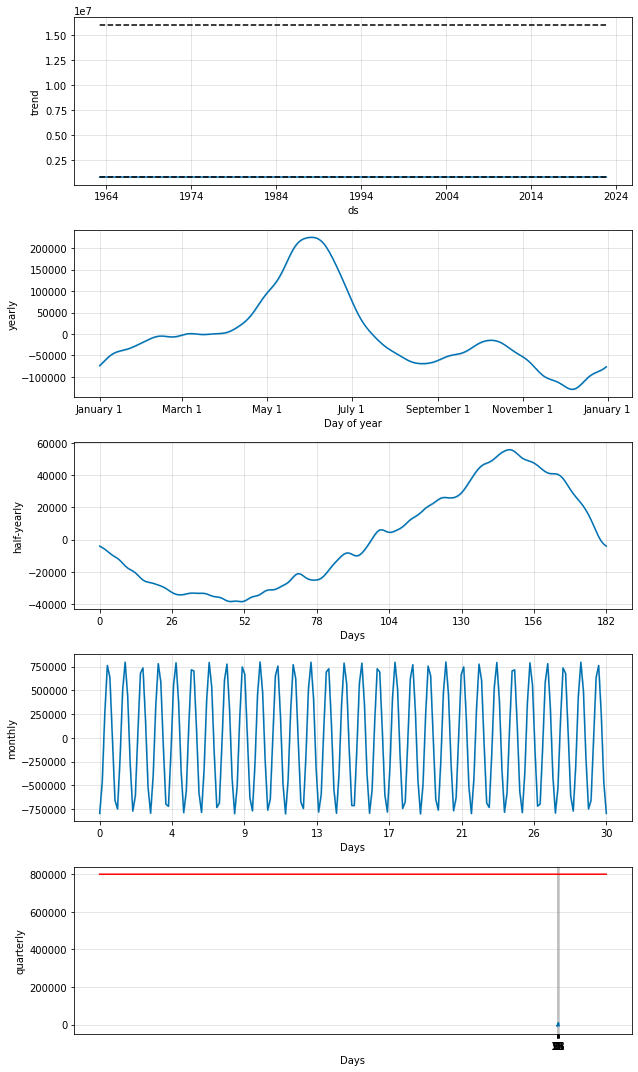

In [12]:
xdat['cap']=16000000
xdat['floor'] = 800000
model = Prophet(seasonality_mode ='additive',yearly_seasonality=False,changepoint_range=0.9,
                        weekly_seasonality=False,daily_seasonality=False,growth='logistic').add_seasonality(
                        name='monthly',period=30,fourier_order=55).add_seasonality(
                        name='quarterly',period=365/4,fourier_order=5,prior_scale=15).add_seasonality(
                        name='yearly',period=365,fourier_order=20,prior_scale=10).add_seasonality(
                        name='half-yearly',period=365/2,fourier_order=35,prior_scale=12)
model.fit(xdat)
future = model.make_future_dataframe(periods = 180, freq = 'D')
future['cap']=16000000
future['floor']=800000
forecast = model.predict(future)
fig = model.plot_components(forecast)
check_points = add_changepoints_to_plot(fig.gca(), model, forecast)

In [14]:
interactive_plot(df,forecast,'final_storage')

## cheking anomaly for final_storage

In [15]:
# anomaly = error > 1.5 * confidance interval

result = pd.concat([xdat.set_index('ds')['y'], 
                    forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') 

fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Checking Anomaly in target')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

**Now let's investigate -Ve inflow (daily scale)**


In [75]:
xdat = train[['Date', 'inflow','unregulated inflow']].rename(
    columns={'Date': 'ds', 'inflow': 'y'})


In [ ]:
xdat['cap']=14000000
xdat['floor'] = -600000
model = Prophet(seasonality_mode ='additive',yearly_seasonality=False,interval_width=0.9,
                        weekly_seasonality=False,daily_seasonality=False,growth='logistic').add_seasonality(
                        name='quarterly',period=365/4,fourier_order=15,prior_scale=10).add_seasonality(
                        name='yearly',period=365,fourier_order=20,prior_scale=15).add_seasonality(
                        name='half-yearly',period=365/2,fourier_order=35,prior_scale=12)

model.fit(xdat)
future = model.make_future_dataframe(periods = 180, freq = 'D')
future['cap']=14000000
future['floor']=-600000
forecast = model.predict(future)
# model.plot_components(forecast)
print()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpacdc5kae/213u753r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpacdc5kae/t72zy1rm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68056', 'data', 'file=/tmp/tmpacdc5kae/213u753r.json', 'init=/tmp/tmpacdc5kae/t72zy1rm.json', 'output', 'file=/tmp/tmpacdc5kae/prophet_model7syf5non/prophet_model-20221214032956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [80]:
interactive_plot(df,forecast,'inflow')

Model can almost predict 1st July ,2022 -ve inflow

**checking anomaly(daily scale)**

In [81]:
result = pd.concat([xdat.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

In [82]:


result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') 

fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Checking Anomaly in target')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

## Check performance metrics

avoiding here as it's taking too much time


In [ ]:

# df_cv = cross_validation(model, initial = '1000 days', period = '45 days', horizon='45 days')
# df_p = performance_metrics(df_cv)
# df_p.head(5)

## Using Prophet for prediction (on monthly scale) 

First converting the daily dataframe to monthly dataframe to verify our results from last 
model

        1. future storage for next 3 months

In [ ]:
xdat_m = xdat.resample('M').mean() # containing the training examples
xdat_m['ds']=xdat_m.index
xdat_m.isnull().sum()
df_m=df.resample('M').mean() # contain both train + test
df_m['Date']=df_m.index

In [ ]:
# xdat_m['cap']=16000000
# xdat_m['floor'] = 800000
# model_m = Prophet(seasonality_mode ='additive',yearly_seasonality=False,
#                         weekly_seasonality=False,daily_seasonality=False,growth='logistic').add_seasonality(
#                         name='quarterly',period=365/4,fourier_order=5,prior_scale=15).add_seasonality(
#                         name='yearly',period=365,fourier_order=20,prior_scale=10).add_seasonality(
#                         name='half-yearly',period=365/2,fourier_order=35,prior_scale=12)
# model_m.fit(xdat_m)
# future_m = model_m.make_future_dataframe(periods = 4, freq = 'M')
# future_m['cap']=16000000
# future_m['floor']=800000
# forecast_m = model_m.predict(future_m)
# # model.plot_components(forecast)
# print()

In [ ]:
# interactive_plot(df_m,forecast_m)


**we might require weather data to investigate the reason for -ve outflow**